# New measure - VSL#3

## Rationale

The Advisory Committee on Borderline Substances (ACBS) is responsible for assessing and recommending products applying for listing in Part XV of the Drug Tariff. The ACBS recently reviewed some products listed in Part XV to ensure they are still clinically effective and appropriate to be listed here. They considered the probiotics VSL#3 and Vivomixx and advised the Secretary of State  for Health and Social Care to remove these products. The Secretary of State accepted this recommendation and removed the products from the drug tariff.


The Committee concluded that the evidence did not sufficiently demonstrate that the products are clinically effective. Additionally the ACBS & MHRA’s consider the presentation of a product to prevent a clinical condition such as pouchitis as a specific medicinal claim. Therefore these products now fall within the definition of a medicine (not  a "borderline" substance) and should be regulated as such. Importantly this means that they are also allowed on prescription, despite them not currently being licnsed as a medicine and having been removed from the drug tariff as the evidence does not support them meeting the threshold for Part XV of the Drug Tariff.

## Proposed Measure

_Title_ : Probiotics that have been removed from the drug tariff

_Description_: Cost of VSL#3 and Vivomixx per 1000 patie

_Why it matters_: The Advisory Committee on Borderline Substances has reconsidered the evidence for VSL#3 and Vivomixx to be listed in part XV of the Drug Tariff. The committee felt that the evidence does not meet the threshold for inclusion and the claims made that these preparations prevent medical conditions means they are more appropirtaely subject to medicines legislation. despite them not currently being licnsed as a medicine and having been removed from the drug tariff as the evidence does not support them meeting the threshold for Part XV of the Drug Tariff.

## Numerators & Denominators

tbc (see SQL below)

## SQL , Results and Graphs

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
#obtain products and CCG level dataframe

sql = """
SELECT
month,
pct,
sum(items) as total_items,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
WHERE
bnf_code LIKE '091104000BBNMA0' ##vsl3
OR bnf_code LIKE '091104000BBNVAO' ##vivomix caps
OR bnf_code LIKE '091104000BBNUAO' ##vivomix powder sachet
 GROUP BY
  month,
  pct
ORDER BY
  month
"""
df_vsl3 = bq.cached_read(sql, csv_path='df_vsl3.csv', use_cache=False)
df_vsl3['month'] = df_vsl3['month'].astype('datetime64[ns]')
df_vsl3.head(3)

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,month,pct,total_items,total_cost
0,2010-08-01,08L,14,547.10
1,2010-08-01,00Y,2,105.27
2,2010-08-01,03R,14,748.99


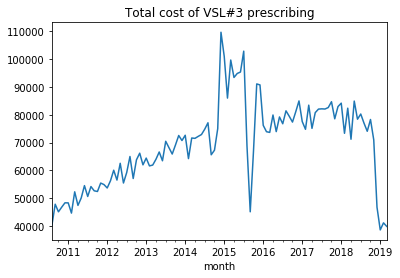

In [3]:
df_vsl3.groupby("month")['total_cost'].sum().plot(kind='line', title="Total cost of VSL#3 prescribing")

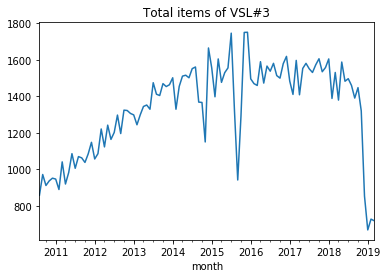

In [4]:
df_vsl3.groupby("month")['total_items'].sum().plot(kind='line', title="Total items of VSL#3")

This looks like a 50% drop once the product was removed.  Although this is heartening that people responded so quickly to the removal of the product from the drug tariff, past experience tells us this is unlikely. This needs fuether investigation specificially (but in no particular order) a) did the bnf code change b) chatting to the team c) change in reimbursement policy inconsistently

In [5]:
##soundslike
sql3 = """
SELECT
bnf_name,
bnf_code,
sum(items) as total_items,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
WHERE
(bnf_name LIKE '%VSL%' 
or bnf_name LIKE '%Vivom%')  ##as soon as i put more than three letters in  it returns no results, hmm?
and (month>='2018-01-01')
 GROUP BY
bnf_name,
bnf_code
"""

df_soundlike = bq.cached_read(sql3, csv_path='df_soundlike.csv')
df_soundlike.head(10)

,bnf_name,bnf_code,total_items,total_cost
0,Vivomixx_Cap,091104000BBNVA0,147,3.704167e+03
1,VSL#3_Probiotic Food Supp Pdr Sach 4.4g,091104000BBNMA0,19052,1.021091e+06
2,Vivomixx_Pdr Sach 4.4g,091104000BBNUA0,689,3.611789e+04


This appears that there is a true drop and there genuinely only are 3 BNF codes associated with these names. Lets move on to measure.

### Measure

In [6]:
##get list size info
sql2 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql2, csv_path='df_list.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2014-04-01,NaN,0.000000
1,2014-04-01,00C,7599.071429
2,2014-04-01,00D,5649.058824
3,2014-04-01,00F,5872.714286
4,2014-04-01,00G,8056.750000


In [7]:
#merge dataframes and cost / 10000

df_vsl_1000 = pd.merge(df_vsl3, df_list, on=['month', 'pct'])
df_vsl_1000['cost_per_1000'] = 1000* (df_vsl_1000['total_cost']/df_vsl_1000['list_size'])
df_vsl_1000.head(5)

,month,pct,total_items,total_cost,list_size,cost_per_1000
0,2014-04-01,06Y,3,103.21,9164.520000,11.261910
1,2014-04-01,09J,9,407.62,7452.676471,54.694445
2,2014-04-01,04V,21,741.67,7297.960784,101.627019
3,2014-04-01,07M,22,782.47,4738.048780,165.146041
4,2014-04-01,99H,10,431.56,7644.051282,56.456973


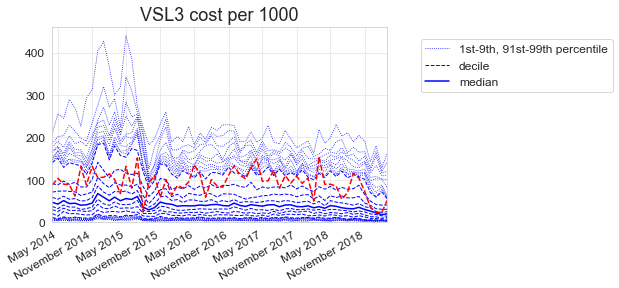

In [8]:
#create sample deciles

charts.deciles_chart(
        df_vsl_1000,
        period_column='month',
        column='cost_per_1000',
        title="VSL3 cost per 1000",
        show_outer_percentiles=True)

#add in example CCG (Islington - 08H)
df_subject = df_vsl_1000.loc[df_vsl_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['cost_per_1000'], 'r--')

plt.show()

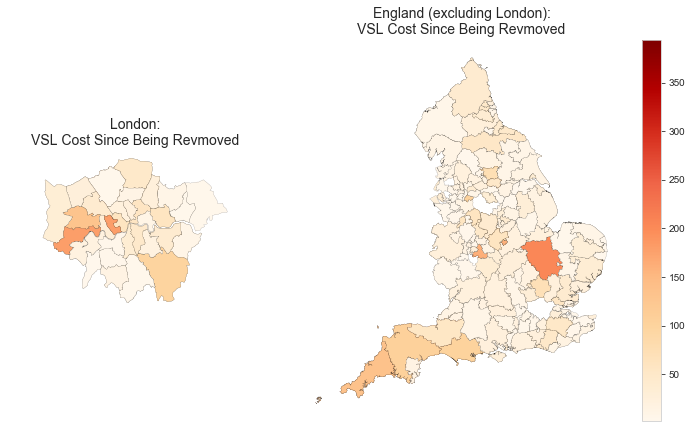

In [9]:
#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_df_vsl_1000 = df_vsl_1000.loc[(df_vsl_1000['month'] >= '2018-11-01') & (df_vsl_1000['month'] <= '2019-01-01')]
plt = maps.ccg_map(latest_df_vsl_1000, title="VSL Cost Since Being Revmoved", column='cost_per_1000', separate_london=True)
plt.show()

if I go to latest months, the CCG changes (i presume) mean this error is returned

##BaseException: Data contains CCG codes we don't know about: ['112']

Alex has sorted this in GBG notebook - remind me to update
